In [31]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [32]:
N = 500

def real_model(x):
    y = (torch.randn(1, N) * 0.2 + 1) * x.pow(2) + (torch.randn(1, N) + 2) * x + 3 + torch.randn(1, N)
    return y

x = torch.linspace(-3, 4, N).view(-1, 1)
y = real_model(x.squeeze()).view(-1, 1)

In [33]:
class NormalModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.mean = None
        self.std = None

        k = 6

        self.hidden_layers = torch.nn.Sequential(
            torch.nn.Linear(1, k),
            torch.nn.ReLU(),
            torch.nn.Linear(k, k)
        )
        self.mean_layer = torch.nn.Linear(k, 1)
        self.std_layer = torch.nn.Sequential(
            torch.nn.Sigmoid(),
            torch.nn.Linear(k, 1),
            torch.nn.ELU()
        )

    def forward(self, x):
        h = self.hidden_layers(x)
        self.mean = self.mean_layer(h)
        self.std = self.std_layer(h) + 1

        return self.mean, self.std
    
    def __repr__(self):
        return f'Mean: {self.mean.item():.5f} and Std: {self.std.item():.5f}'


In [34]:
def k(mean, std, x):
    return 1 / np.sqrt(2 * np.pi) * torch.exp(-((x - mean)/std) ** 2 / 2) / std

def log_k(mean, std, y):
    return -torch.log(std) - (y - mean)**2 / (2 * std**2)

In [35]:
model = NormalModel()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [36]:
max_epoch = 20000
for epoch in range(max_epoch):
    opt.zero_grad()

    if epoch % 10 == 0 and max_epoch - epoch > 100:
        sample = torch.randint(N, (1, 100)).squeeze()
    elif max_epoch - epoch == 100:
        sample = torch.arange(0, N)

    mean, std = model(x[sample])
    log_likelyhood = log_k(mean, std, y[sample]).sum()
    loss = -log_likelyhood
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f'{epoch}:: Loss = {loss.item()}')
    


0:: Loss = 13213.6552734375
100:: Loss = 243.86602783203125
200:: Loss = 162.1765899658203
300:: Loss = 151.73062133789062
400:: Loss = 143.37518310546875
500:: Loss = 173.88063049316406
600:: Loss = 153.0498809814453
700:: Loss = 126.61128997802734
800:: Loss = 166.81756591796875
900:: Loss = 168.41714477539062
1000:: Loss = 129.34327697753906
1100:: Loss = 132.419677734375
1200:: Loss = 123.21824645996094
1300:: Loss = 140.88897705078125
1400:: Loss = 171.8953857421875
1500:: Loss = 158.24728393554688
1600:: Loss = 130.9645538330078
1700:: Loss = 128.3985595703125
1800:: Loss = 145.3741455078125
1900:: Loss = 128.8151092529297
2000:: Loss = 129.98904418945312
2100:: Loss = 127.90471649169922
2200:: Loss = 126.74652099609375
2300:: Loss = 123.888427734375
2400:: Loss = 133.86976623535156
2500:: Loss = 125.10689544677734
2600:: Loss = 135.57449340820312
2700:: Loss = 113.8702392578125
2800:: Loss = 130.41488647460938
2900:: Loss = 131.16192626953125
3000:: Loss = 144.6595458984375
3100

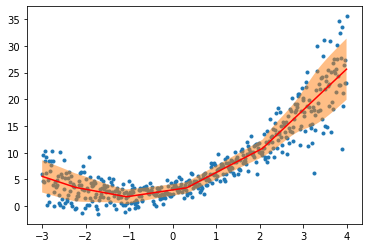

In [37]:
m, s = model(x)

plt.scatter(x, y, marker='.')
plt.plot(x, m.detach(), 'r')
plt.fill_between(x.squeeze(), (m.detach()-s.detach()).squeeze(), (m.detach()+s.detach()).squeeze(), alpha=0.5)

In [38]:
x.size(), y.size()

(torch.Size([500, 1]), torch.Size([500, 1]))

In [39]:
def check_within_two_stddeviations(x, y):
    y_pred, y_std = model(x)
    # want 95.4% inside 
    a = (y - y_pred).abs() / y_std
    hits = (a <= 2).sum()
    return hits / len(x)

In [40]:
check_within_two_stddeviations(x, y) - 0.954

tensor(0.0120)

In [41]:
np.sqrt(0.96 * 0.04 / N)

0.008763560920082658

---
# using polynomial functions

In [42]:
def eval_powers_of_x(x, n):
    return x.pow(torch.arange(n))

In [43]:
class NormalPolynomialModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.mean = None
        self.std = None
        
        self.N_mean = 3 # constant, linear, quadratic, ... terms
        self.N_var = 2 * self.N_mean - 1

        self.poly_multipliers_mean = torch.nn.parameter.Parameter(torch.rand(self.N_mean))
        self.poly_multipliers_var = torch.nn.parameter.Parameter(torch.rand(self.N_var))
        self.var_shift = torch.nn.parameter.Parameter(torch.tensor(0.1))

        self.mean_layer = torch.nn.Linear(self.N_mean, 1)
        self.var_layer = torch.nn.Sequential(
            torch.nn.Linear(self.N_var, 1),
            torch.nn.ReLU()
        )
    
    def forward(self, x):
        self.mean = self.mean_layer(self.poly_multipliers_mean * eval_powers_of_x(x, self.N_mean))
        self.var = self.var_layer(self.poly_multipliers_var * eval_powers_of_x(x, self.N_var)) + self.var_shift ** 2
        return self.mean, self.var
    


In [44]:
def log_k_with_var(mean, var, y):
    return -0.5*torch.log(var) - (y - mean)**2 / (2 * var)

In [45]:
model = NormalPolynomialModel()
opt = torch.optim.Adam(model.parameters())

max_epoch = 20000
for epoch in range(max_epoch):
    opt.zero_grad()

    # if we want to use a little bit of randomness in our decent
    # (could possibly avoid local minimums?),
    # index x and y by sample below
    if epoch % 10 == 0 and max_epoch - epoch > 50:
        sample = torch.randint(N, (1, 250)).squeeze()
    elif max_epoch - epoch == 100:
        sample = torch.arange(0, N)

    mean, var = model(x[sample])
    log_likelyhood = log_k_with_var(mean, var, y[sample]).sum()
    loss = -log_likelyhood
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f'{epoch}:: Loss = {loss.item()}')
    

0:: Loss = 7855.07763671875
100:: Loss = 3824.104248046875
200:: Loss = 2572.31787109375
300:: Loss = 2150.769775390625
400:: Loss = 1646.6148681640625
500:: Loss = 1313.3929443359375
600:: Loss = 1145.6953125
700:: Loss = 945.7607421875
800:: Loss = 784.380126953125
900:: Loss = 795.4573974609375
1000:: Loss = 642.490234375
1100:: Loss = 632.5689086914062
1200:: Loss = 586.337158203125
1300:: Loss = 599.9973754882812
1400:: Loss = 536.772216796875
1500:: Loss = 482.7357177734375
1600:: Loss = 508.3629455566406
1700:: Loss = 526.4475708007812
1800:: Loss = 504.40447998046875
1900:: Loss = 498.3326416015625
2000:: Loss = 470.4004211425781
2100:: Loss = 468.88336181640625
2200:: Loss = 486.40142822265625
2300:: Loss = 457.75921630859375
2400:: Loss = 474.7137145996094
2500:: Loss = 445.1480407714844
2600:: Loss = 462.08551025390625
2700:: Loss = 443.0609130859375
2800:: Loss = 378.56231689453125
2900:: Loss = 389.3935241699219
3000:: Loss = 380.0986633300781
3100:: Loss = 365.44290161132

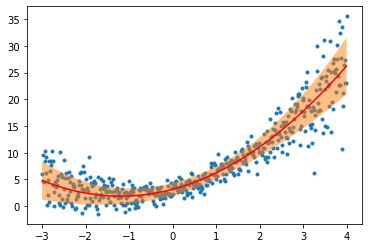

In [46]:
m, var = model(x)
s = var.sqrt()

plt.scatter(x, y, marker='.')
plt.plot(x, m.detach(), 'r')
plt.fill_between(x.squeeze(), (m.detach()-s.detach()).squeeze(), (m.detach()+s.detach()).squeeze(), alpha=0.5)